라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 5
model_name = 'Test230728_tank5_lstm_nodo'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)

In [9]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [10]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 8
nCar: 64621 nVar: 180
nCar: 64621 nVar: 8
nCar: 64621 nVar: 180


In [11]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [12]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 8
nCar: 64441 nVar: 180
nCar: 64441 nVar: 8
nCar: 64441 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [13]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(180, 8), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-28 04:35:25.008754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 04:35:25.570810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:52:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 128)          70144     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 180)               5940      
Total params: 137,908
Trainable params: 137,908
Non-trainable params: 0
_________________________________________________________________


2023-07-28 04:35:27.623912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-28 04:35:31.634116: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-28 04:35:32.907346: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 113s 54ms/step - loss: 9.4681 - mae: 2.0257 - r_squared: -1.7926 - val_loss: 3.6060 - val_mae: 1.3358 - val_r_squared: -115.7653
Epoch 2/200
2014/2014 [==============================] - 105s 52ms/step - loss: 3.6081 - mae: 1.3394 - r_squared: -0.0324 - val_loss: 3.6055 - val_mae: 1.3393 - val_r_squared: -117.2003
Epoch 3/200
2014/2014 [==============================] - 105s 52ms/step - loss: 3.6096 - mae: 1.3398 - r_squared: -0.0320 - val_loss: 3.6061 - val_mae: 1.3398 - val_r_squared: -117.2274
Epoch 4/200
2014/2014 [==============================] - 105s 52ms/step - loss: 2.6364 - mae: 1.1198 - r_squared: 0.2311 - val_loss: 2.0042 - val_mae: 0.9767 - val_r_squared: -54.1590
Epoch 5/200
2014/2014 [==============================] - 105s 52ms/step - loss: 1.9694 - mae: 0.9603 - r_squared: 0.4020 - val_loss: 1.8896 - val_mae: 0.9374 - val_r_squared: -52.7128
Epoch 6/200
2014/2014 [==============================] - 105s 52ms/step - loss: 1.8961

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 105s 52ms/step - loss: 1.4433 - mae: 0.7741 - r_squared: 0.5605 - val_loss: 1.3967 - val_mae: 0.7712 - val_r_squared: -13.5132
Epoch 21/200
2014/2014 [==============================] - 105s 52ms/step - loss: 1.4183 - mae: 0.7668 - r_squared: 0.5685 - val_loss: 1.3747 - val_mae: 0.7416 - val_r_squared: -15.1565
Epoch 22/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.4375 - mae: 0.7768 - r_squared: 0.5610 - val_loss: 1.4124 - val_mae: 0.7524 - val_r_squared: -16.2181
Epoch 23/200
2014/2014 [==============================] - 105s 52ms/step - loss: 1.3768 - mae: 0.7457 - r_squared: 0.5811 - val_loss: 1.3827 - val_mae: 0.7600 - val_r_squared: -12.7701
Epoch 24/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.4591 - mae: 0.7869 - r_squared: 0.5555 - val_loss: 1.4934 - val_mae: 0.8322 - val_r_squared: -22.0010

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 1.1612 - mae: 0.6618 - r_squared: 0.6480 - val_loss: 1.1446 - val_mae: 0.6586 - val_r_squared: -8.1080
Epoch 40/200
2014/2014 [==============================] - 105s 52ms/step - loss: 1.1551 - mae: 0.6578 - r_squared: 0.6477 - val_loss: 1.1617 - val_mae: 0.6727 - val_r_squared: -7.7245
Epoch 41/200
1279/2014 [==================>...........] - ETA: 26s - loss: 1.1524 - mae: 0.6568 - r_squared: 0.6501

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 105s 52ms/step - loss: 1.1434 - mae: 0.6520 - r_squared: 0.6530 - val_loss: 1.1382 - val_mae: 0.6590 - val_r_squared: -7.7889
Epoch 43/200
1925/2014 [===========================>..] - ETA: 3s - loss: 1.1298 - mae: 0.6471 - r_squared: 0.6563

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 1.0665 - mae: 0.6236 - r_squared: 0.6768 - val_loss: 1.0653 - val_mae: 0.6216 - val_r_squared: -5.5547
Epoch 55/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.0632 - mae: 0.6231 - r_squared: 0.6773 - val_loss: 1.0610 - val_mae: 0.6209 - val_r_squared: -5.5499
Epoch 56/200
 503/2014 [======>.......................] - ETA: 54s - loss: 1.0839 - mae: 0.6271 - r_squared: 0.6724

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 1.0576 - mae: 0.6215 - r_squared: 0.6784 - val_loss: 1.0612 - val_mae: 0.6187 - val_r_squared: -5.6520
Epoch 59/200
 544/2014 [=======>......................] - ETA: 53s - loss: 1.0677 - mae: 0.6273 - r_squared: 0.6770

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 105s 52ms/step - loss: 1.0395 - mae: 0.6171 - r_squared: 0.6856 - val_loss: 1.0350 - val_mae: 0.6172 - val_r_squared: -5.5038
Epoch 67/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.0370 - mae: 0.6169 - r_squared: 0.6855 - val_loss: 1.0444 - val_mae: 0.6242 - val_r_squared: -5.5678
Epoch 68/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.0348 - mae: 0.6164 - r_squared: 0.6861 - val_loss: 1.0350 - val_mae: 0.6206 - val_r_squared: -5.4635
Epoch 69/200
 929/2014 [============>.................] - ETA: 39s - loss: 1.0226 - mae: 0.6128 - r_squared: 0.6848

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 1.0118 - mae: 0.6130 - r_squared: 0.6934 - val_loss: 1.0060 - val_mae: 0.6126 - val_r_squared: -5.3088
Epoch 80/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.0102 - mae: 0.6131 - r_squared: 0.6915 - val_loss: 1.0082 - val_mae: 0.6118 - val_r_squared: -5.2896
Epoch 81/200
 243/2014 [==>...........................] - ETA: 1:03 - loss: 1.0324 - mae: 0.6172 - r_squared: 0.6991

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 1.0065 - mae: 0.6125 - r_squared: 0.6944 - val_loss: 1.0058 - val_mae: 0.6134 - val_r_squared: -5.3310
Epoch 83/200
 577/2014 [=======>......................] - ETA: 51s - loss: 0.9925 - mae: 0.6066 - r_squared: 0.7025

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 0.9883 - mae: 0.6070 - r_squared: 0.7009 - val_loss: 0.9871 - val_mae: 0.6067 - val_r_squared: -5.1571
Epoch 93/200
2014/2014 [==============================] - 105s 52ms/step - loss: 0.9875 - mae: 0.6070 - r_squared: 0.6995 - val_loss: 0.9877 - val_mae: 0.6056 - val_r_squared: -5.1436
Epoch 94/200
2014/2014 [==============================] - 105s 52ms/step - loss: 0.9873 - mae: 0.6068 - r_squared: 0.7014 - val_loss: 0.9867 - val_mae: 0.6060 - val_r_squared: -5.1532
Epoch 95/200
1051/2014 [==============>...............] - ETA: 34s - loss: 0.9775 - mae: 0.6031 - r_squared: 0.7039

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 103s 51ms/step - loss: 0.9848 - mae: 0.6065 - r_squared: 0.6995 - val_loss: 0.9842 - val_mae: 0.6061 - val_r_squared: -5.1472
Epoch 105/200
1105/2014 [===============>..............] - ETA: 32s - loss: 0.9913 - mae: 0.6074 - r_squared: 0.7040

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 0.9841 - mae: 0.6061 - r_squared: 0.7002 - val_loss: 0.9839 - val_mae: 0.6054 - val_r_squared: -5.1246
Epoch 107/200
2014/2014 [==============================] - 104s 52ms/step - loss: 0.9842 - mae: 0.6059 - r_squared: 0.7022 - val_loss: 0.9833 - val_mae: 0.6056 - val_r_squared: -5.1459
Epoch 108/200
 421/2014 [=====>........................] - ETA: 57s - loss: 0.9602 - mae: 0.5995 - r_squared: 0.7024

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 0.9820 - mae: 0.6056 - r_squared: 0.7006 - val_loss: 0.9822 - val_mae: 0.6048 - val_r_squared: -5.1352

Epoch 00117: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 118/200
1391/2014 [===================>..........] - ETA: 22s - loss: 0.9754 - mae: 0.6042 - r_squared: 0.7053

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 104s 52ms/step - loss: 0.9811 - mae: 0.6053 - r_squared: 0.7021 - val_loss: 0.9810 - val_mae: 0.6054 - val_r_squared: -5.1403
Epoch 121/200
 985/2014 [=============>................] - ETA: 37s - loss: 1.0062 - mae: 0.6100 - r_squared: 0.6970

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 103s 51ms/step - loss: 0.9809 - mae: 0.6052 - r_squared: 0.7015 - val_loss: 0.9809 - val_mae: 0.6052 - val_r_squared: -5.1361
Epoch 130/200
2014/2014 [==============================] - 103s 51ms/step - loss: 0.9809 - mae: 0.6052 - r_squared: 0.7015 - val_loss: 0.9809 - val_mae: 0.6052 - val_r_squared: -5.1361

Epoch 00130: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 131/200
2014/2014 [==============================] - 104s 52ms/step - loss: 0.9810 - mae: 0.6052 - r_squared: 0.7021 - val_loss: 0.9809 - val_mae: 0.6052 - val_r_squared: -5.1361
Epoch 132/200
2014/2014 [==============================] - 105s 52ms/step - loss: 0.9809 - mae: 0.6052 - r_squared: 0.7006 - val_loss: 0.9809 - val_mae: 0.6052 - val_r_squared: -5.1361
Epoch 133/200
2014/2014 [==============================] - 104s 52ms/step - loss: 0.9809 - mae: 0.6052 - r_squared: 0.6989 - val_loss: 0.9809 - val_mae: 0.6052 - val_r_squared: -5.1361

Epoch 0

모델 평가

In [14]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [15]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.05930109 -0.07837668 -0.00359154 ...  0.09638946  0.10234614
  -0.01972547]
 [ 0.10121093  0.19766922  0.0725908  ... -0.08871789 -0.03059849
  -0.08653516]
 [ 0.05185344  0.2028608  -0.04394058 ... -0.06569847  0.00613848
   0.07072564]
 ...
 [-0.05374147  0.16876207  0.01406147 ...  0.09688842  0.09002747
   0.04646759]
 [ 0.0367952   0.6057819  -0.027623   ...  0.02060887 -0.00314299
  -0.10279341]
 [ 0.02877334  0.71153563 -0.03701312 ... -0.03801233 -0.11742238
  -0.01362342]]


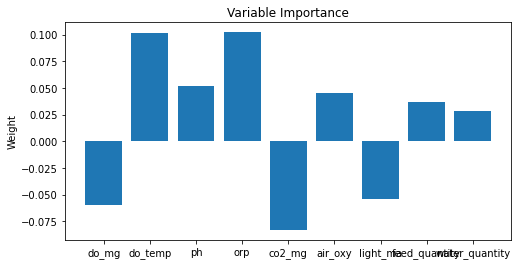

In [16]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [17]:
japonica_validation_features_X

,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,
2021-07-21 00:00:00,7.7,30.2,5.57,195.6,13.7,0.0,3.9,0.0,0.0
2021-07-21 00:01:00,7.8,30.2,5.57,195.9,13.7,0.0,4.0,0.0,0.0
2021-07-21 00:02:00,7.8,30.2,5.57,196.1,13.7,0.0,4.0,0.0,0.0
2021-07-21 00:03:00,7.8,30.2,5.57,196.4,13.7,0.0,3.9,0.0,0.0
2021-07-21 00:04:00,7.9,30.2,5.57,196.6,13.8,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-09-08 23:55:00,8.7,29.0,5.25,149.3,22.3,0.0,3.9,0.0,0.0
2021-09-08 23:56:00,8.7,29.0,5.25,149.8,22.3,0.0,3.9,0.0,0.0
2021-09-08 23:57:00,8.7,29.0,5.25,149.9,22.3,0.0,4.0,0.0,0.0


In [18]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 360 nVar: 180


In [19]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 360 nVar: 180


64800


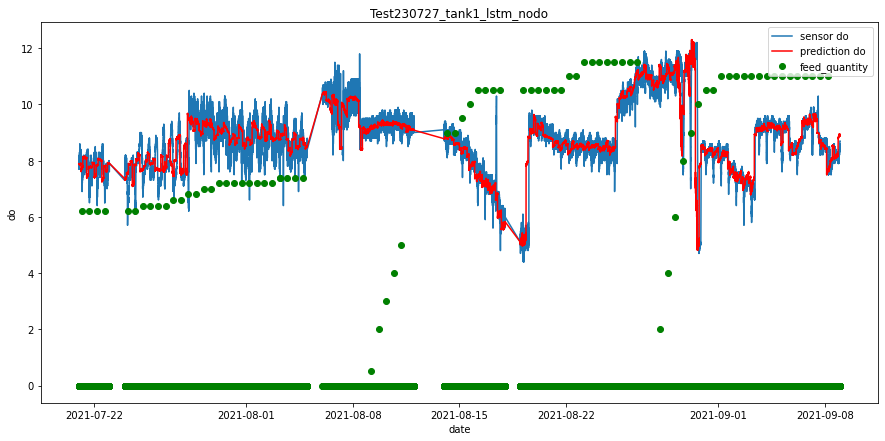

12/12 [==============================] - 1s 16ms/step - loss: 0.3962 - mae: 0.3717 - r_squared: 0.3822
MSE // MAE // R-squared  [0.39620441198349, 0.37169981002807617, 0.3821938931941986]


In [20]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [21]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 9


In [22]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 1
nCar: 14220 nVar: 1


In [23]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

ValueError: in user code:

    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/engine/input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 9)


In [ ]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [ ]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [ ]:
japonica_validation_features_X.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)